In [325]:
# AIM: Data Preprocessing
# this work includes:
#   1. Data Cleaning
#      - Handling missing data
#      - Handling Near-Zero Variance (NZV) columns
#      - Dealing with Outliers
#      - Structural Errors: They don't necessarily look like "errors" to a computer, but they mess up 
#                           your analysis.
#      - Handling Noise: Noise is random error or variance in a measured variable.
#      - Removing Duplicates: Ensuring that the model doesn't "over-learn" from the same data point 
#                             repeated multiple times.
#   2. Data Transformation:
#      - Feature Scaling for ML
#      - Encoding Categorical Data: Converting text (like "Red," "Green," "Blue") into numbers.
#   3. Data Reduction: More data isn't always better. Too many irrelevant features can confuse a model 
#      - Feature Selection: Identifying and keeping only the most important variables.
#      - Principal Component Analysis (PCA): A mathematical technique that compresses many features into 
#         a few "principal components" while keeping as much information as possible.


#   Note: Data Integration (Sometimes data comes from different sources) is not need here.

In [326]:
# Import libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
from sklearn.impute import SimpleImputer # for handling missing data
from sklearn.experimental import enable_iterative_imputer # for MICE
from sklearn.impute import IterativeImputer # for MICE
from sklearn.preprocessing import OrdinalEncoder # for MICE

In [327]:
#import dataset (for train and test))
train_set = pd.read_csv('/kaggle/input/project-data/train.csv')
train_set = train_set.drop(train_set.columns[0], axis=1) # drop Id column "meaningless"
X_train = train_set.iloc[:, :-1].values 
y_train = train_set.iloc[:, -1].values

test_set = pd.read_csv('/kaggle/input/project-data/test.csv')
test_set = test_set.drop(train_set.columns[0], axis=1) # drop Id column "meaningless"
X_test = test_set.iloc[:, :].values # test file has no SalePrice column


In [328]:
print(train_set)

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60       RL         62.0     7917   Pave   NaN      Reg   
1456          20       RL         85.0    13175   Pave   NaN      Reg   
1457          70       RL         66.0     9042   Pave   NaN      Reg   
1458          20       RL         68.0     9717   Pave   NaN      Reg   
1459          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
0            Lvl    AllPub    Inside  ...  

In [329]:
print(y_train)

[208500 181500 223500 ... 266500 142125 147500]


In [330]:
print(X_test)

[[1461 'RH' 80.0 ... 2010 'WD' 'Normal']
 [1462 'RL' 81.0 ... 2010 'WD' 'Normal']
 [1463 'RL' 74.0 ... 2010 'WD' 'Normal']
 ...
 [2917 'RL' 160.0 ... 2006 'WD' 'Abnorml']
 [2918 'RL' 62.0 ... 2006 'WD' 'Normal']
 [2919 'RL' 74.0 ... 2006 'WD' 'Normal']]


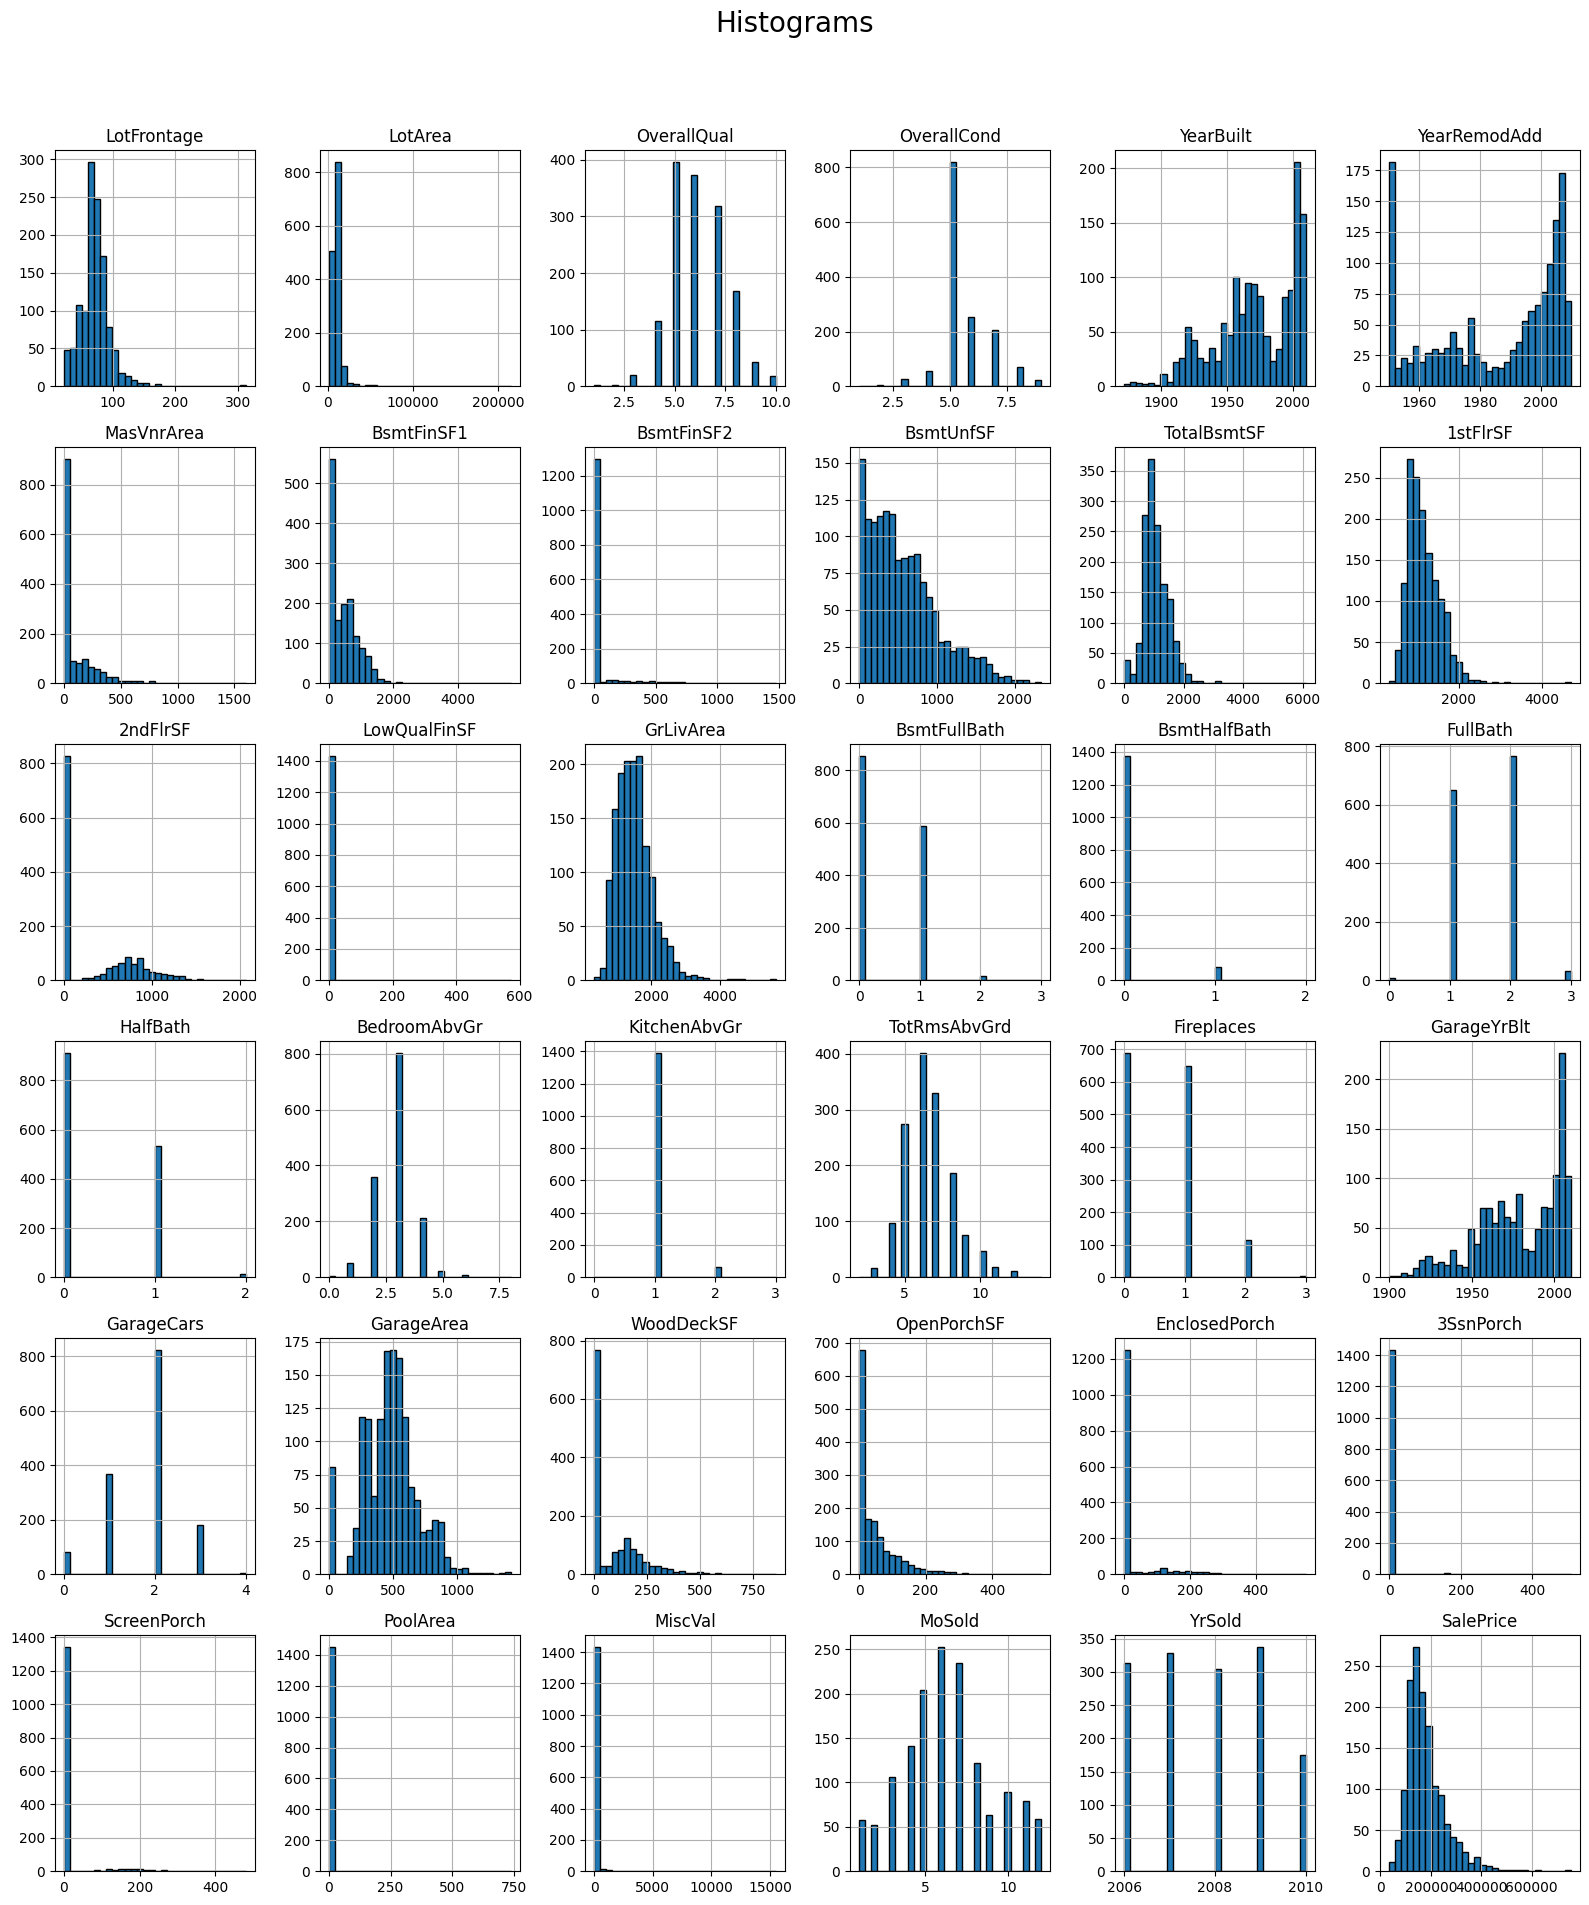

In [331]:
# Plotting all histograms

features = train_set.iloc[:, 1:]

# figsize scales the plot area; layout automatically arranges the grid
features.hist(figsize=(16, 20), bins=30, edgecolor='black')

plt.suptitle('Histograms', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

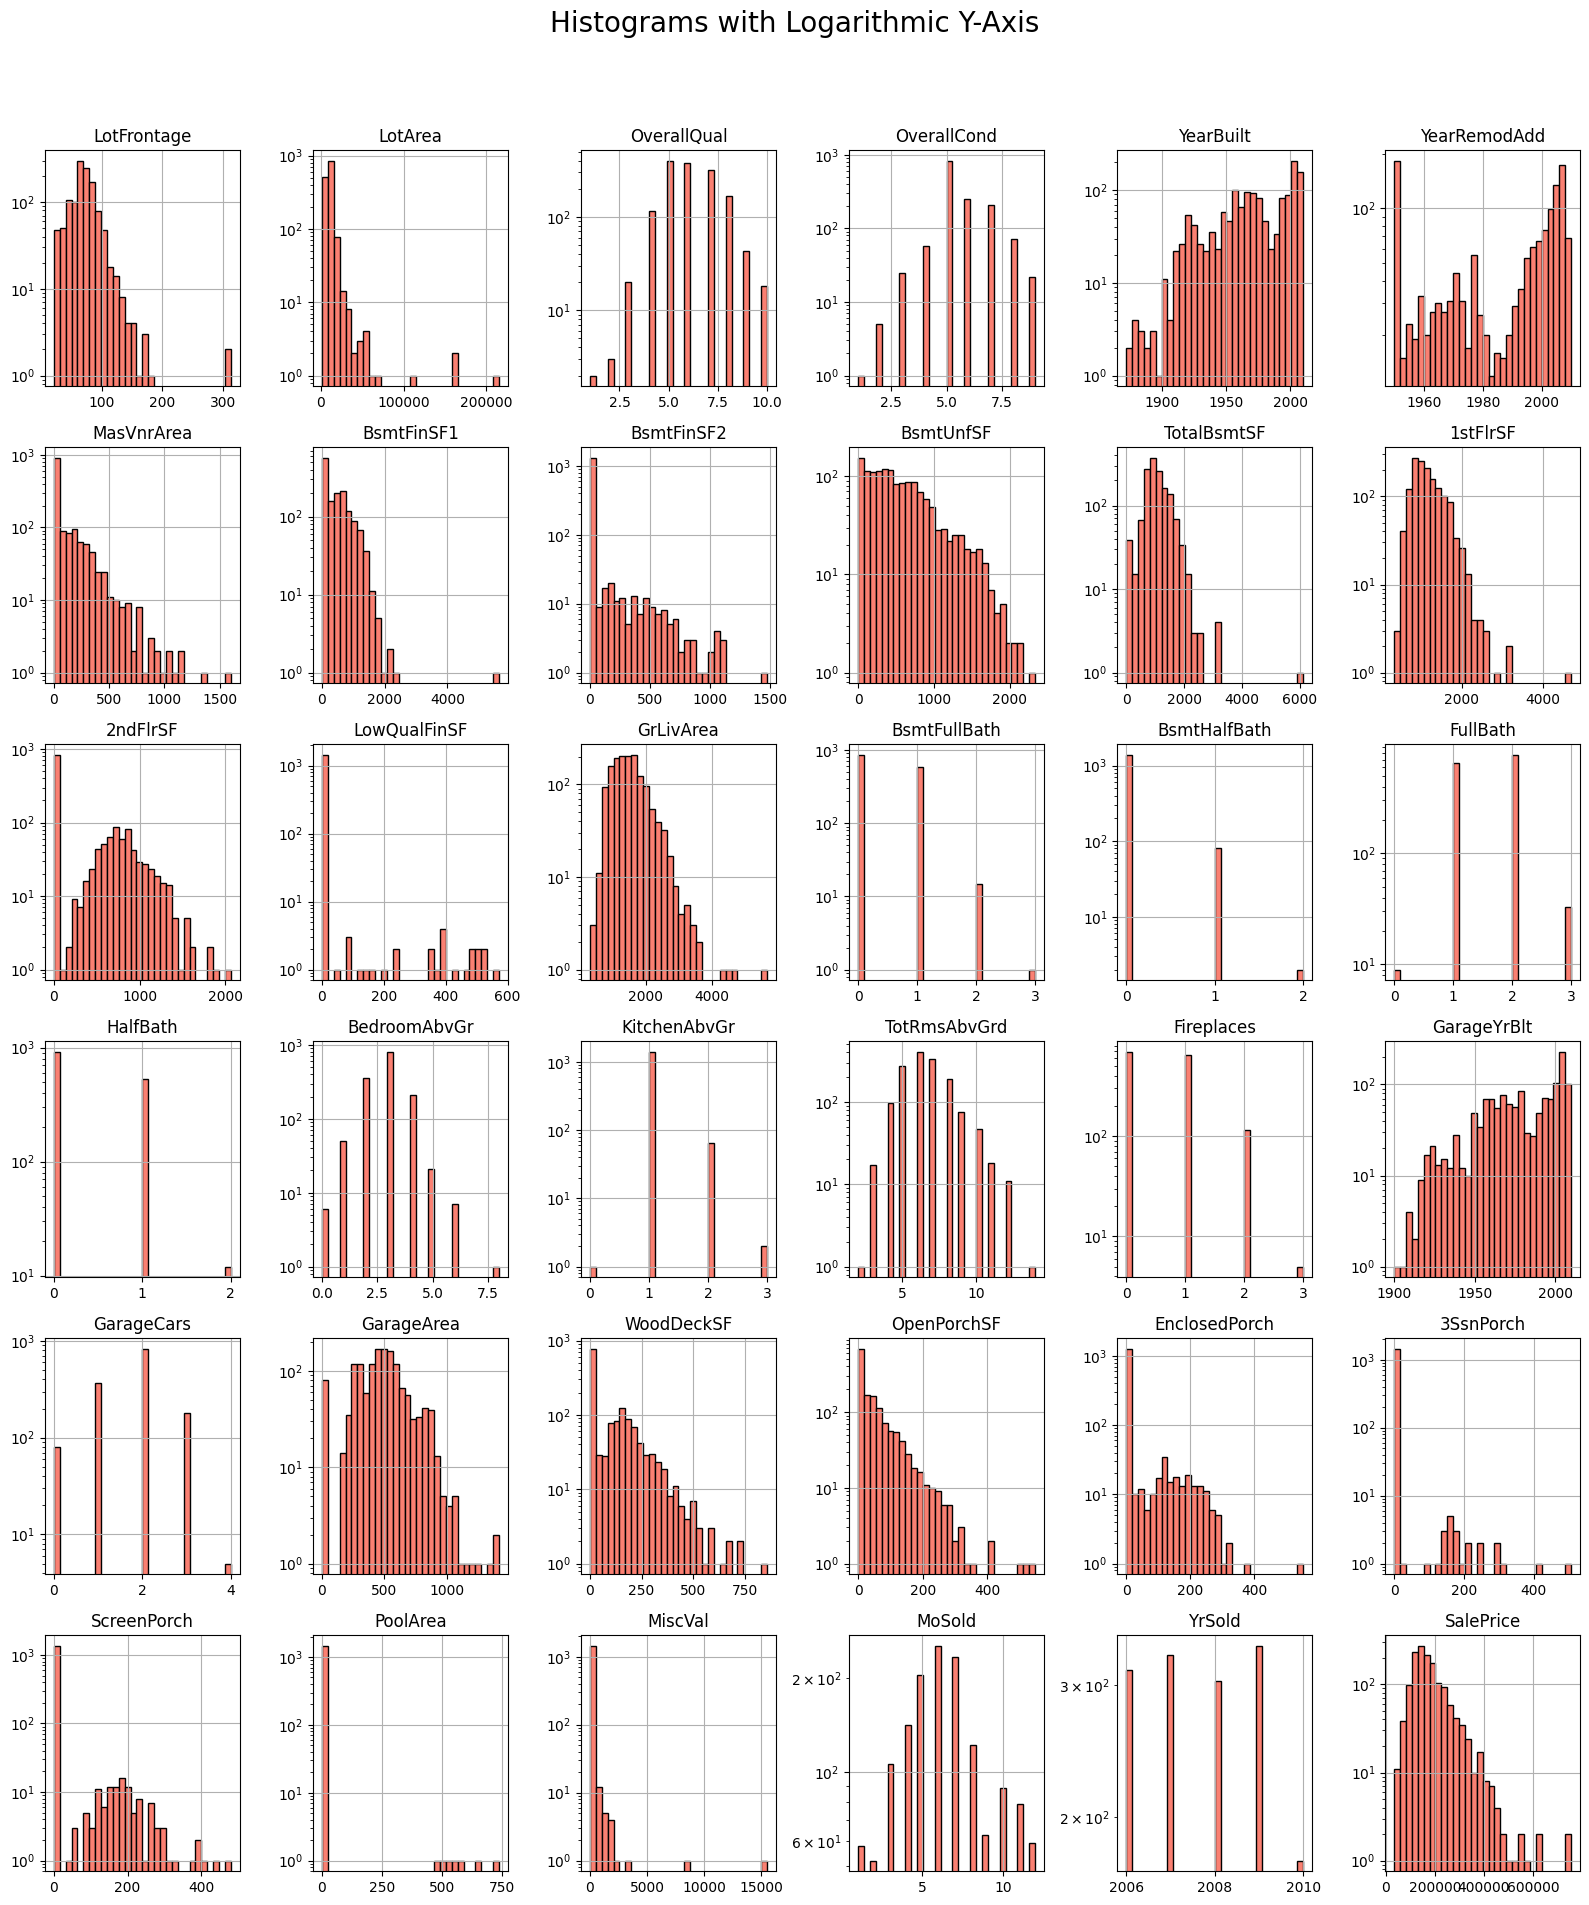

In [332]:
# plotting histrograms with log(y-axis) to see small values 
#features = train_set.iloc[:, 1:]
features.hist(figsize=(16, 20), bins=30, edgecolor='black', log=True, color='salmon')

plt.suptitle('Histograms with Logarithmic Y-Axis', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [333]:
############################################################################################
################################## Handling missing data ###################################
############################################################################################

In [334]:
# Criteria of handling missing data:
#
#    Missing %   Strategy                  Recommended Action
#    0% - 5%     Fast & Simple             Use Simple Imputation (Mean/Median/Mode) or Listwise Deletion 
#                                          (drop the rows). At this low level, the impact on your model 
#                                          is minimal.
#    5% – 30%    Statistical Imputation    Don't drop. Use Predictive Imputation (KNN or MICE) to preserve
#                                          the relationships between variables. Simple Mean/Median might 
#                                          start to "shrink" your variance too much here.
#    30% – 50%   Advanced / Strategic      Use Advanced Imputation and always add a Missingness Indicator 
#                                          (a new binary column that says "Was_Missing: True/False"). This
#                                          tells the model that the absence of data might be a pattern.
#    > 50%       Deletion or Feature Eng.  Generally, Drop the Column. It’s hard to "guess" half of a 
#                                          variable accurately. Only keep it if you believe the fact that 
#                                          it's missing is the most important signal.

# Before starting dealing with the Criteria, CHECK THE FOLLOWING NOTE. 
# NOTE: When a missing value actually represents a specific state (like "No Room," "No Garage," or "No Pool"),
#       it is technically NOT "missing" data. In this specific case, YOU SHOULD NOT DROP THE COLUMN.
#       For categorical columns: fill missing data with the Mode (the most frequent value)
#       For numerical columns: fill missing data with the Median (to avoid outlier influence)

In [335]:
# Data cleaning
# Handling Missing Data

# Missing Data statistics
missing_count = train_set.isnull().sum()
missing_percentage = (train_set.isnull().sum() / len(train_set)) * 100
data_types = train_set.dtypes
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print(missing_only)

              Total Missing  Percent (%)     Type
PoolQC                 1453    99.520548   object
MiscFeature            1406    96.301370   object
Alley                  1369    93.767123   object
Fence                  1179    80.753425   object
MasVnrType              872    59.726027   object
FireplaceQu             690    47.260274   object
LotFrontage             259    17.739726  float64
GarageQual               81     5.547945   object
GarageType               81     5.547945   object
GarageFinish             81     5.547945   object
GarageCond               81     5.547945   object
GarageYrBlt              81     5.547945  float64
BsmtExposure             38     2.602740   object
BsmtFinType2             38     2.602740   object
BsmtQual                 37     2.534247   object
BsmtFinType1             37     2.534247   object
BsmtCond                 37     2.534247   object
MasVnrArea                8     0.547945  float64
Electrical                1     0.068493   object


Missing data in PoolQC       => No Pool

Missing data in MiscFeature  => Missing data

Missing data in Alley        => No alley access

Missing data in Fence        => No Fence

Missing data in MasVnrType   => Missing data

Missing data in FireplaceQu  => No Fireplace

Missing data in LotFrontage  => Missing data

Missing data in GarageQual   => No Garage

Missing data in GarageFinish => No Garage

Missing data in GarageType   => No Garage

Missing data in GarageYrBlt  => No Garage

Missing data in GarageCond   => No Garage

Missing data in BsmtFinType2 => No Basement

Missing data in BsmtExposure => No Basement

Missing data in BsmtCond     => No Basement

Missing data in BsmtQual     => No Basement

Missing data in BsmtFinType1 => No Basement

Missing data in MasVnrArea   => Missing data

Missing data in Electrical   => Missing data

Note: 
              Total Missing  Percent (%)     Type
GarageYrBlt              81     5.547945  float64
GarageQual               81     5.547945   object
GarageCond               81     5.547945   object
GarageType               81     5.547945   object
GarageFinish             81     5.547945   object

GarageType: Garage location
GarageYrBlt: Year garage was built
GarageFinish: Interior finish of the garage
GarageCars: Size of garage in car capacity
GarageArea: Size of garage in square feet
GarageQual: Garage quality
GarageCond: Garage condition

These missing data are related to the same readings. there are 81 readings (rows) that have missing GarageYrBlt, GarageQual, GarageCond, GarageType and GarageFinish values .

It is noticed that each one of these 81 readings (appartments) have GarageCars = 0 and GarageArea = 0
this means that these appartments has no garage.

In [336]:
# Dealing with the 81 appartment that do not have a garage
# For Categorical Columns replace the missing value with string "None"
# For Numerical Columns replace the missing value with string 0 

# List of Garage columns
garage_cat_cols = ['GarageQual', 'GarageCond', 'GarageType', 'GarageFinish']
garage_num_cols = ['GarageYrBlt']

train_set[garage_cat_cols] = train_set[garage_cat_cols].fillna("None")
train_set[garage_num_cols] = train_set[garage_num_cols].fillna(0)

print("Missing values in Garage columns after specific handling:")
print(train_set[garage_cat_cols + garage_num_cols].isnull().sum())

Missing values in Garage columns after specific handling:
GarageQual      0
GarageCond      0
GarageType      0
GarageFinish    0
GarageYrBlt     0
dtype: int64


In [337]:
# Checking the fixing of the appartments that have no garage
missing_count = train_set.isnull().sum()
missing_percentage = (train_set.isnull().sum() / len(train_set)) * 100
data_types = train_set.dtypes
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print(missing_only)

              Total Missing  Percent (%)     Type
PoolQC                 1453    99.520548   object
MiscFeature            1406    96.301370   object
Alley                  1369    93.767123   object
Fence                  1179    80.753425   object
MasVnrType              872    59.726027   object
FireplaceQu             690    47.260274   object
LotFrontage             259    17.739726  float64
BsmtExposure             38     2.602740   object
BsmtFinType2             38     2.602740   object
BsmtCond                 37     2.534247   object
BsmtQual                 37     2.534247   object
BsmtFinType1             37     2.534247   object
MasVnrArea                8     0.547945  float64
Electrical                1     0.068493   object


Note :
              Total Missing  Percent (%)     Type
BsmtExposure             38     2.602740   object
BsmtFinType2             38     2.602740   object
BsmtCond                 37     2.534247   object
BsmtFinType1             37     2.534247   object
BsmtQual                 37     2.534247   object


BsmtExposure: Walkout or garden level basement walls
       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

BsmtFinType2: Rating of basement finished area (if multiple types) / Quality of second finished area (if present)
       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtCond: Evaluates the general condition of the basement
       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

BsmtFinType1: Rating of basement finished area
       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtQual: Evaluates the height of the basement
       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement


these indicate that there is 37 appartments have no basement and 1 appartment with undefined BsmtExposure value and undefined BsmtFinType2 value

In [338]:
# Dealing with the 37 appartments having no basement and 1 appartment with undefined BsmtExposure value 
# and undefined BsmtFinType2 value

bsmt_cols_to_fix = ['BsmtExposure', 'BsmtFinType2', 'BsmtCond', 'BsmtFinType1', 'BsmtQual']

train_set[bsmt_cols_to_fix] = train_set[bsmt_cols_to_fix].fillna("None")

# Verify
print("Missing values after update:")
print(train_set[bsmt_cols_to_fix].isnull().sum())


Missing values after update:
BsmtExposure    0
BsmtFinType2    0
BsmtCond        0
BsmtFinType1    0
BsmtQual        0
dtype: int64


In [339]:
# Checking the fixing of the 37 appartments having no basement and 1 appartment with undefined 
# BsmtExposure value and undefined BsmtFinType2 value

missing_count = train_set.isnull().sum()
missing_percentage = (train_set.isnull().sum() / len(train_set)) * 100
data_types = train_set.dtypes
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print(missing_only)

             Total Missing  Percent (%)     Type
PoolQC                1453    99.520548   object
MiscFeature           1406    96.301370   object
Alley                 1369    93.767123   object
Fence                 1179    80.753425   object
MasVnrType             872    59.726027   object
FireplaceQu            690    47.260274   object
LotFrontage            259    17.739726  float64
MasVnrArea               8     0.547945  float64
Electrical               1     0.068493   object


In [340]:
# Dealing with the other variables that have missing data and their missing data represent a specific state
# (as ex. "No Room")
# These varaibles are : PoolQC, Alley, Fence, FireplaceQu 
# Note that they are categorical data

cat_cols_to_fix = ['PoolQC', 'Alley', 'Fence', 'FireplaceQu']

train_set[cat_cols_to_fix] = train_set[cat_cols_to_fix].fillna("None")

# Verify
print("Missing values after update:")
print(train_set[cat_cols_to_fix].isnull().sum())

Missing values after update:
PoolQC         0
Alley          0
Fence          0
FireplaceQu    0
dtype: int64


In [341]:
# Checking the fixing of the the other variables that have missing data and their missing data represent
# a specific state (as ex. "No Room")

missing_count = train_set.isnull().sum()
missing_percentage = (train_set.isnull().sum() / len(train_set)) * 100
data_types = train_set.dtypes
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print(missing_only)

             Total Missing  Percent (%)     Type
MiscFeature           1406    96.301370   object
MasVnrType             872    59.726027   object
LotFrontage            259    17.739726  float64
MasVnrArea               8     0.547945  float64
Electrical               1     0.068493   object


In [342]:
# Remove the column with missing data percentage > 50%  
missing_percentage = (train_set.isnull().sum() / len(train_set)) * 100
cols_to_drop = missing_percentage[missing_percentage > 50].index.tolist()
train_set.drop(columns=cols_to_drop, inplace=True)

# Apply the same drops to your test set
test_set.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped columns: {cols_to_drop}")
print(f"New shape of train_set: {train_set.shape}")
print(f"New shape of test_set: {test_set.shape}")

Dropped columns: ['MasVnrType', 'MiscFeature']
New shape of train_set: (1460, 78)
New shape of test_set: (1459, 77)


In [343]:
# Checking the removing of the column with missing data percentage > 50%
missing_count = train_set.isnull().sum()
missing_percentage = (train_set.isnull().sum() / len(train_set)) * 100
data_types = train_set.dtypes
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print(missing_only)

             Total Missing  Percent (%)     Type
LotFrontage            259    17.739726  float64
MasVnrArea               8     0.547945  float64
Electrical               1     0.068493   object


In [344]:
# Dealing with the columns that their missing values are [0% , 5%] of their whole data
# To do:
#     - fill missing data in categorical columns with the Mode (the most frequent value)
#     - fill missing data in numerical columns with the Median (to avoid outlier influence)


# Handling missing data in categorical columns with missing data [0% , 5%]

missing_pct = (train_set.isnull().sum() / len(train_set)) * 100
target_categorical_cols = [
    col for col in train_set.select_dtypes(include=['object']).columns 
    if 0 < missing_pct[col] <= 5
]

if target_categorical_cols:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    train_set[target_categorical_cols] = cat_imputer.fit_transform(train_set[target_categorical_cols])
    print(f"Imputed columns: {target_categorical_cols}")
else:
    print("No categorical columns found with 0% to 5% missing data.")

# Verify
print("Remaining missing values in these columns:", 
      train_set[target_categorical_cols].isnull().sum().sum())

Imputed columns: ['Electrical']
Remaining missing values in these columns: 0


In [345]:
# Checking the fixing of the categorical column with missing data percentage [0% , 5%]
missing_count = train_set.isnull().sum()
missing_percentage = (train_set.isnull().sum() / len(train_set)) * 100
data_types = train_set.dtypes
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print(missing_only)

             Total Missing  Percent (%)     Type
LotFrontage            259    17.739726  float64
MasVnrArea               8     0.547945  float64


In [346]:
# Handling missing data in numerical columns with missing data [0% , 5%]

missing_pct = (train_set.isnull().sum() / len(train_set)) * 100

target_numerical_cols = [
    col for col in train_set.select_dtypes(include=['int64', 'float64']).columns 
    if 0 < missing_pct[col] <= 5
]

if len(target_numerical_cols) > 0:
    num_imputer = SimpleImputer(strategy='median')
    train_set[target_numerical_cols] = num_imputer.fit_transform(train_set[target_numerical_cols])
    print(f"Successfully imputed columns: {target_numerical_cols}")
else:
    print("No numerical columns found with missing data between 0% and 5%.")

# Verify
print("Remaining missing values in targeted columns:",
      train_set[target_numerical_cols].isnull().sum().sum())

Successfully imputed columns: ['MasVnrArea']
Remaining missing values in targeted columns: 0


In [347]:
# Checking the fixing of the numerical column with missing data percentage [0% , 5%]
missing_count = train_set.isnull().sum()
missing_percentage = (train_set.isnull().sum() / len(train_set)) * 100
data_types = train_set.dtypes
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print(missing_only)

             Total Missing  Percent (%)     Type
LotFrontage            259    17.739726  float64


In [348]:
# Dealing with the columns that their missing values are [5% , 30%] of their whole data

# 1. Select the core columns for prediction
# We include LotFrontage (the target) and the features we discussed
predictive_cols = [
    'LotFrontage', 'LotArea', 'LotConfig', 
    'LotShape', 'Neighborhood', 'BldgType', 'MSZoning'
]

# Create a copy of the subset to work on
train_set_sub = train_set[predictive_cols].copy()

# 2. Convert Categorical data to Numbers
# MICE cannot handle strings like 'Corner' or 'RL', so we encode them
encoder = OrdinalEncoder()

# Identify columns that are objects/strings
cat_cols = ['LotConfig', 'LotShape', 'Neighborhood', 'BldgType', 'MSZoning']

# Encode categories while preserving NaNs
# We only fit on non-null values to avoid encoding the missing data as a category
for col in cat_cols:
    non_null_mask = train_set_sub[col].notnull()
    reshaped_vals = train_set_sub.loc[non_null_mask, col].values.reshape(-1, 1)
    train_set_sub.loc[non_null_mask, col] = encoder.fit_transform(reshaped_vals)

# 3. Apply Iterative Imputer (MICE)
# initial_strategy='median' fills gaps before the first iteration starts
# max_iter=10 is usually enough for values to converge
mice_imputer = IterativeImputer(random_state=42, max_iter=10, initial_strategy='median')

# Fit and transform the data
imputed_data = mice_imputer.fit_transform(train_set_sub)

# 4. Bring the data back into a DataFrame
train_set_imputed = pd.DataFrame(imputed_data, columns=predictive_cols, index=train_set.index)

# Update your original dataframe with the newly calculated LotFrontage
train_set['LotFrontage'] = train_set_imputed['LotFrontage']

print(f"Missing values in LotFrontage after MICE: {train_set['LotFrontage'].isnull().sum()}")

Missing values in LotFrontage after MICE: 0


In [349]:
# Checking the fixing of the column with missing data percentage [5% , 30%]
missing_count = train_set.isnull().sum()
missing_percentage = (train_set.isnull().sum() / len(train_set)) * 100
data_types = train_set.dtypes
missing_data = pd.concat([missing_count, missing_percentage, data_types], 
                         axis=1, 
                         keys=['Total Missing', 'Percent (%)', 'Type'])
missing_data = missing_data.sort_values(by='Total Missing', ascending=False)
missing_only = missing_data[missing_data['Total Missing'] > 0]

print(missing_only)

Empty DataFrame
Columns: [Total Missing, Percent (%), Type]
Index: []


In [350]:
# Check correlation after imputation
print(train_set[['LotFrontage', 'LotArea']].corr())

             LotFrontage   LotArea
LotFrontage     1.000000  0.508958
LotArea         0.508958  1.000000


A correlation of 0.509 is a very positive sign. It confirms that your MICE imputation was successful and logically consistent. 

In [351]:
# Sanity Check after imputation, While the correlation looks good, you should check for extreme values. 
# Sometimes predictive models can predict a negative number or a massive outlier if the input data is 
# strange.

print(train_set['LotFrontage'].describe())

count    1460.000000
mean       71.285791
std        23.785529
min        21.000000
25%        60.000000
50%        71.000000
75%        82.000000
max       313.000000
Name: LotFrontage, dtype: float64


The count is exactly 1460, which is the total number of rows in the standard Ames housing dataset. This confirms that 100% of the missing values (the 17%) have been filled.

The Mean and the Median are almost identical, it means your data is symmetrical and well-distributed.

In [352]:
############################################################################################
######################## Handling Near-Zero Variance (NZV) columns ######################### 
############################################################################################

In [353]:
# Criteria of Handling Near-Zero Variance (NZV) columns
# 
#    Condition        Data Type     Recommended Action  Why?
#    Variance = 0,    Any           Drop                The column is a constant. It is impossible for a 
#                                                       model to learn from a constant.
#    95% - 99% Same   Categorical   Drop                The rare cases are likely noise or "special cases"
#                                                       that don't help general predictions."
#    95% - 99% Same   Numerical     Binarize (0/1),     Convert it to "Has Feature" vs "No Feature" 
#                                                       (e.g., PoolArea → HasPool)."
#    80% - 95% Same   Categorical   Group "Rare",       Combine all tiny categories into one label called 
#                                                       "Other"
#
#
# for Discrete Columns
#    If the Discrete Column is      Recommended Action  Why?
#    Constant                       Drop                Zero variance; no predictive power.
#    (e.g., all have 1 kitchen)
#    Mostly one value (>95%)        Binarize            Transform into "Has Multiple Kitchens (0 or 1).
#    Small range (e.g., 1 to 4)     Keep as is          The model can handle small integers easily.
#    Large range (e.g., YearBuilt)  Feature Engineer,   Convert to "Age of House" (Current Year - YearBuilt).

In [354]:
# ------------------------ For categorical columns ------------------------
# Getting Frequency Ratio (the percentage of the most common value) of categorical columns

cat_cols = train_set.select_dtypes(include=['object', 'category']).columns
frequency_data = []

for col in cat_cols:
    value_counts = train_set[col].value_counts(normalize=True)
    
    if not value_counts.empty:
        most_common_val = value_counts.index[0]
        most_common_pct = value_counts.iloc[0] * 100
        
        frequency_data.append({
            'Column': col,
            'Most Common Value': most_common_val,
            'Frequency Ratio (%)': round(most_common_pct, 2)
        })

frequency_df = pd.DataFrame(frequency_data).sort_values(by='Frequency Ratio (%)', ascending=False)

print("Categorical Columns with High Imbalance (>80%):")
print(frequency_df[frequency_df['Frequency Ratio (%)'] > 80])

Categorical Columns with High Imbalance (>80%):
           Column Most Common Value  Frequency Ratio (%)
5       Utilities            AllPub                99.93
1          Street              Pave                99.59
37         PoolQC              None                99.52
10     Condition2              Norm                98.97
14       RoofMatl           CompShg                98.22
25        Heating              GasA                97.81
7       LandSlope               Gtl                94.66
2           Alley              None                93.77
27     CentralAir                 Y                93.49
30     Functional               Typ                93.15
36     PavedDrive                 Y                91.78
28     Electrical             SBrkr                91.44
35     GarageCond                TA                90.82
4     LandContour               Lvl                89.79
34     GarageQual                TA                89.79
21       BsmtCond                TA     

In [355]:
# Droping the columns with Frequency Ratio > 95%

def drop_high_imbalance_cats(df, threshold=95.0):
    """
    Identifies and drops categorical columns where the most frequent 
    value exceeds the given percentage threshold.
    """
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    cols_to_drop = []

    print(f"Checking {len(cat_cols)} categorical columns for imbalance > {threshold}%...\n")

    for col in cat_cols:
        value_counts = df[col].value_counts(normalize=True)
        
        if not value_counts.empty:
            most_freq_pct = value_counts.iloc[0] * 100
            
            if most_freq_pct > threshold:
                print(f"DROPPING: [{col}] - Most frequent value: '{value_counts.index[0]}' ({most_freq_pct:.2f}%)")
                cols_to_drop.append(col)

    df_cleaned = df.drop(columns=cols_to_drop)
    
    print(f"\nSuccessfully dropped {len(cols_to_drop)} columns.")
    print(f"Remaining columns: {df_cleaned.shape[1]}")
    
    return df_cleaned, cols_to_drop

train_set, dropped_list = drop_high_imbalance_cats(train_set, threshold=95.0)

# Apply the same drops to your test set
test_set = test_set.drop(columns=dropped_list)

print(f"New shape of train_set: {train_set.shape}")
print(f"New shape of test_set: {test_set.shape}")

Checking 41 categorical columns for imbalance > 95.0%...

DROPPING: [Street] - Most frequent value: 'Pave' (99.59%)
DROPPING: [Utilities] - Most frequent value: 'AllPub' (99.93%)
DROPPING: [Condition2] - Most frequent value: 'Norm' (98.97%)
DROPPING: [RoofMatl] - Most frequent value: 'CompShg' (98.22%)
DROPPING: [Heating] - Most frequent value: 'GasA' (97.81%)
DROPPING: [PoolQC] - Most frequent value: 'None' (99.52%)

Successfully dropped 6 columns.
Remaining columns: 72
New shape of train_set: (1460, 72)
New shape of test_set: (1459, 71)


In [356]:
# Checking after droping the columns with Frequency Ratio > 95%

cat_cols = train_set.select_dtypes(include=['object', 'category']).columns
frequency_data = []

for col in cat_cols:
    value_counts = train_set[col].value_counts(normalize=True)
    
    if not value_counts.empty:
        most_common_val = value_counts.index[0]
        most_common_pct = value_counts.iloc[0] * 100
        
        frequency_data.append({
            'Column': col,
            'Most Common Value': most_common_val,
            'Frequency Ratio (%)': round(most_common_pct, 2)
        })

frequency_df = pd.DataFrame(frequency_data).sort_values(by='Frequency Ratio (%)', ascending=False)

print("Categorical Columns with High Imbalance (>80%):")
print(frequency_df[frequency_df['Frequency Ratio (%)'] > 80])

Categorical Columns with High Imbalance (>80%):
           Column Most Common Value  Frequency Ratio (%)
5       LandSlope               Gtl                94.66
1           Alley              None                93.77
22     CentralAir                 Y                93.49
25     Functional               Typ                93.15
31     PavedDrive                 Y                91.78
23     Electrical             SBrkr                91.44
30     GarageCond                TA                90.82
29     GarageQual                TA                89.79
3     LandContour               Lvl                89.79
17       BsmtCond                TA                89.79
14      ExterCond                TA                87.81
33       SaleType                WD                86.78
7      Condition1              Norm                86.30
20   BsmtFinType2               Unf                86.03
8        BldgType              1Fam                83.56
34  SaleCondition            Normal     

Regarding the next step: for Categorical with 80% - 95% of their values are same -> Combine all tiny categories into one label called "Other"

CentralAir: Central air conditioning already has two values (N -> No and Y -> Yes), so it can be excluded.

In [357]:
# For Categorical with 80% - 95% of their values are same -> Combine all tiny categories into one label
# called "Other"

def group_rare_categories(df, lower_thresh=80.0, upper_thresh=95.0):
    """
    Groups minority categories into 'Other' for columns where the 
    majority value is between 80% and 95%.
    Excludes binary columns (columns with only 2 unique values).
    """
    # 1. Identify categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    
    print(f"Analyzing columns for grouping (Threshold: {lower_thresh}% - {upper_thresh}%)...\n")

    for col in cat_cols:
        # Get number of unique values
        unique_count = df[col].nunique()
        
        # Skip binary columns (like CentralAir)
        if unique_count <= 2:
            continue
            
        # Get the frequency of the most common value
        value_counts_pct = df[col].value_counts(normalize=True) * 100
        most_freq_pct = value_counts_pct.iloc[0]
        
        # Check if it falls within the 80% - 95% range
        if lower_thresh <= most_freq_pct < upper_thresh:
            most_common_label = value_counts_pct.index[0]
            
            # Identify the "tiny" labels (everything except the most common one)
            # We replace them with 'Other'
            df[col] = df[col].apply(lambda x: x if x == most_common_label else 'Other')
            
            print(f"GROUPED: [{col}] - Kept '{most_common_label}', grouped others into 'Other'.")
            
    return df

# Execution
train_set = group_rare_categories(train_set)

Analyzing columns for grouping (Threshold: 80.0% - 95.0%)...

GROUPED: [Alley] - Kept 'None', grouped others into 'Other'.
GROUPED: [LandContour] - Kept 'Lvl', grouped others into 'Other'.
GROUPED: [LandSlope] - Kept 'Gtl', grouped others into 'Other'.
GROUPED: [Condition1] - Kept 'Norm', grouped others into 'Other'.
GROUPED: [BldgType] - Kept '1Fam', grouped others into 'Other'.
GROUPED: [ExterCond] - Kept 'TA', grouped others into 'Other'.
GROUPED: [BsmtCond] - Kept 'TA', grouped others into 'Other'.
GROUPED: [BsmtFinType2] - Kept 'Unf', grouped others into 'Other'.
GROUPED: [Electrical] - Kept 'SBrkr', grouped others into 'Other'.
GROUPED: [Functional] - Kept 'Typ', grouped others into 'Other'.
GROUPED: [GarageQual] - Kept 'TA', grouped others into 'Other'.
GROUPED: [GarageCond] - Kept 'TA', grouped others into 'Other'.
GROUPED: [PavedDrive] - Kept 'Y', grouped others into 'Other'.
GROUPED: [Fence] - Kept 'None', grouped others into 'Other'.
GROUPED: [SaleType] - Kept 'WD', grouped 

In [358]:
# Checking for Categorical with 80% - 95% of their values are same after Combine all tiny categories into
# one label

def check_grouping_results(df, lower_thresh=80.0, upper_thresh=95.0):
    """
    Identifies columns that fit the 80-95% majority criteria, 
    displays their new values ('Majority' vs 'Other'), and their percentages.
    """
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    results_found = False

    print(f"{'Column Name':<20} | {'Value':<15} | {'Percentage'}")
    print("-" * 50)

    for col in cat_cols:
        # Skip binary columns (like CentralAir)
        if df[col].nunique() <= 2 and 'Other' not in df[col].values:
            continue
            
        # Check value counts
        counts_pct = df[col].value_counts(normalize=True) * 100
        
        # We look for columns where the top value is 80-95%
        # AND it has an 'Other' category (meaning grouping happened)
        if lower_thresh <= counts_pct.iloc[0] < upper_thresh and 'Other' in counts_pct.index:
            results_found = True
            for val, pct in counts_pct.items():
                print(f"{col:<20} | {val:<15} | {pct:.2f}%")
            print("-" * 50)

    if not results_found:
        print("No columns found matching the grouping criteria. Did you run the grouping function first?")

# Run the check
check_grouping_results(train_set)

Column Name          | Value           | Percentage
--------------------------------------------------
Alley                | None            | 93.77%
Alley                | Other           | 6.23%
--------------------------------------------------
LandContour          | Lvl             | 89.79%
LandContour          | Other           | 10.21%
--------------------------------------------------
LandSlope            | Gtl             | 94.66%
LandSlope            | Other           | 5.34%
--------------------------------------------------
Condition1           | Norm            | 86.30%
Condition1           | Other           | 13.70%
--------------------------------------------------
BldgType             | 1Fam            | 83.56%
BldgType             | Other           | 16.44%
--------------------------------------------------
ExterCond            | TA              | 87.81%
ExterCond            | Other           | 12.19%
--------------------------------------------------
BsmtCond         

In [359]:
# ------------------------ For numerical Discrete columns ------------------------
#
#    Scenario              Majority Value %     Recommended Action
#    Constant              100%	               Drop (Always)
#    Extremely Imbalanced  96% - 99%	           Drop (Almost always)
#    Highly Imbalanced     90% - 95%	           Binarize
#   Moderately Imbalanced  70% - 89%	           Keep but group rare categories into "Other"

# Getting Discrete Columns Frequency Report

numeric_cols = train_set.select_dtypes(include=['number']).columns
discrete_cols = [col for col in numeric_cols if train_set[col].nunique() < 20]

discrete_summary = []

for col in discrete_cols:
    counts_pct = train_set[col].value_counts(normalize=True) * 100
    
    most_freq_val = counts_pct.index[0]
    most_freq_pct = counts_pct.iloc[0]
    num_unique = train_set[col].nunique()
    
    discrete_summary.append({
        'Column': col,
        'Most Frequent Value': most_freq_val,
        'Frequency (%)': round(most_freq_pct, 2),
        'Unique Values': num_unique
    })

discrete_df = pd.DataFrame(discrete_summary).sort_values(by='Frequency (%)', ascending=False)

print("--- Discrete Columns Frequency Report ---")
print(discrete_df)

# Highlight potential Near-Zero Variance issues (> 95%)
nzv_discrete = discrete_df[discrete_df['Frequency (%)'] > 95]
if not nzv_discrete.empty:
    print("\nWarning: These discrete columns are >95% identical and may need Binarization or Dropping:")
    print(nzv_discrete['Column'].tolist())

--- Discrete Columns Frequency Report ---
          Column  Most Frequent Value  Frequency (%)  Unique Values
12      PoolArea                    0          99.52              8
8   KitchenAbvGr                    1          95.34              4
4   BsmtHalfBath                    0          94.38              3
6       HalfBath                    0          62.53              3
3   BsmtFullBath                    0          58.63              4
11    GarageCars                    2          56.44              5
2    OverallCond                    5          56.23              9
7   BedroomAbvGr                    3          55.07              8
5       FullBath                    2          52.60              4
10    Fireplaces                    0          47.26              4
0     MSSubClass                   20          36.71             15
9   TotRmsAbvGrd                    6          27.53             12
1    OverallQual                    5          27.19             10
14    

In [360]:
# Drop the discrete columns with frequency > 95%

def drop_nzv_discrete(df, unique_thresh=20, freq_thresh=95.0):
    """
    Identifies discrete numerical columns and drops them if the 
    most frequent value exceeds freq_thresh.
    """
    
    numeric_cols = df.select_dtypes(include=['number']).columns
    cols_to_drop = []

    print(f"Scanning discrete columns for imbalance > {freq_thresh}%...")

    for col in numeric_cols:
        # Define 'Discrete' as having fewer than 'unique_thresh' unique values
        if df[col].nunique() < unique_thresh:
            # Calculate frequency of the most common value
            counts_pct = df[col].value_counts(normalize=True) * 100
            most_freq_pct = counts_pct.iloc[0]
            
            if most_freq_pct > freq_thresh:
                print(f"DROPPING: [{col}] - Most common value '{counts_pct.index[0]}' appears {most_freq_pct:.2f}% of the time.")
                cols_to_drop.append(col)

    
    df_cleaned = df.drop(columns=cols_to_drop)
    
    print(f"\nSuccessfully dropped {len(cols_to_drop)} discrete columns.")
    return df_cleaned, cols_to_drop

train_set, dropped_discrete_list = drop_nzv_discrete(train_set)

# Apply the exact same drops to the test set
test_set = test_set.drop(columns=dropped_discrete_list)


print(f"New shape of train_set: {train_set.shape}")
print(f"New shape of test_set: {test_set.shape}")

Scanning discrete columns for imbalance > 95.0%...
DROPPING: [KitchenAbvGr] - Most common value '1' appears 95.34% of the time.
DROPPING: [PoolArea] - Most common value '0' appears 99.52% of the time.

Successfully dropped 2 discrete columns.
New shape of train_set: (1460, 70)
New shape of test_set: (1459, 69)


In [361]:
# Checking the drop the discrete columns with frequency > 95%
numeric_cols = train_set.select_dtypes(include=['number']).columns
discrete_cols = [col for col in numeric_cols if train_set[col].nunique() < 20]

discrete_summary = []

for col in discrete_cols:
    counts_pct = train_set[col].value_counts(normalize=True) * 100
    
    most_freq_val = counts_pct.index[0]
    most_freq_pct = counts_pct.iloc[0]
    num_unique = train_set[col].nunique()
    
    discrete_summary.append({
        'Column': col,
        'Most Frequent Value': most_freq_val,
        'Frequency (%)': round(most_freq_pct, 2),
        'Unique Values': num_unique
    })

discrete_df = pd.DataFrame(discrete_summary).sort_values(by='Frequency (%)', ascending=False)

print("--- Discrete Columns Frequency Report ---")
print(discrete_df)

# Highlight potential Near-Zero Variance issues (> 95%)
nzv_discrete = discrete_df[discrete_df['Frequency (%)'] > 95]
if not nzv_discrete.empty:
    print("\nWarning: These discrete columns are >95% identical and may need Binarization or Dropping:")
    print(nzv_discrete['Column'].tolist())

--- Discrete Columns Frequency Report ---
          Column  Most Frequent Value  Frequency (%)  Unique Values
4   BsmtHalfBath                    0          94.38              3
6       HalfBath                    0          62.53              3
3   BsmtFullBath                    0          58.63              4
10    GarageCars                    2          56.44              5
2    OverallCond                    5          56.23              9
7   BedroomAbvGr                    3          55.07              8
5       FullBath                    2          52.60              4
9     Fireplaces                    0          47.26              4
0     MSSubClass                   20          36.71             15
8   TotRmsAbvGrd                    6          27.53             12
1    OverallQual                    5          27.19             10
12        YrSold                 2009          23.15              5
11        MoSold                    6          17.33             12


In [362]:
# Binarize the discrete columns where the most frequent value is between 90% and 95%

binarization_map = {} # This will store {column_name: majority_value}
numeric_cols = train_set.select_dtypes(include=['number']).columns

for col in numeric_cols:
    # Filter for discrete (less than 20 unique values)
    if train_set[col].nunique() < 20:
        counts_pct = train_set[col].value_counts(normalize=True) * 100
        most_freq_pct = counts_pct.iloc[0]
        
        # Target the 90% - 95% range
        if 90.0 <= most_freq_pct <= 95.0:
            binarization_map[col] = train_set[col].mode()[0]

# --- STEP 2: Apply the Binarization to both Train and Test ---
def apply_binarization(df, mapping):
    df_copy = df.copy()
    for col, maj_val in mapping.items():
        if col in df_copy.columns:
            new_col_name = f"{col}_is_{maj_val}"
            # Create binary flag: 1 if it matches training majority, 0 otherwise
            df_copy[new_col_name] = (df_copy[col] == maj_val).astype(int)
            # Drop original
            df_copy.drop(columns=[col], inplace=True)
            print(f"Processed {col}: Created {new_col_name}")
    return df_copy

# Execute the transformation
train_set = apply_binarization(train_set, binarization_map)
test_set = apply_binarization(test_set, binarization_map)

Processed BsmtHalfBath: Created BsmtHalfBath_is_0
Processed BsmtHalfBath: Created BsmtHalfBath_is_0


In [363]:
print(train_set.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'Fence', 'MiscVal',
       'MoSold', 'YrSo

In [364]:
train_set.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,3SsnPorch,ScreenPorch,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,BsmtHalfBath_is_0
0,60,RL,65.0,8450,None,Reg,Lvl,Inside,Gtl,CollgCr,...,0,0,None,0,2,2008,WD,Normal,208500,1
1,20,RL,80.0,9600,None,Reg,Lvl,FR2,Gtl,Veenker,...,0,0,None,0,5,2007,WD,Normal,181500,0
2,60,RL,68.0,11250,None,IR1,Lvl,Inside,Gtl,CollgCr,...,0,0,None,0,9,2008,WD,Normal,223500,1
3,70,RL,60.0,9550,None,IR1,Lvl,Corner,Gtl,Crawfor,...,0,0,None,0,2,2006,WD,Other,140000,1
4,60,RL,84.0,14260,None,IR1,Lvl,FR2,Gtl,NoRidge,...,0,0,None,0,12,2008,WD,Normal,250000,1


In [365]:
# Moving 'SalePrice' column to be the last column in the train_set

cols = list(train_set.columns)
cols.remove('SalePrice')
cols.append('SalePrice')
train_set = train_set[cols]

# Check the last 5 columns to verify
print(train_set.iloc[:, -5:].columns)

Index(['YrSold', 'SaleType', 'SaleCondition', 'BsmtHalfBath_is_0',
       'SalePrice'],
      dtype='object')


In [366]:
train_set.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,3SsnPorch,ScreenPorch,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,BsmtHalfBath_is_0,SalePrice
0,60,RL,65.0,8450,None,Reg,Lvl,Inside,Gtl,CollgCr,...,0,0,None,0,2,2008,WD,Normal,1,208500
1,20,RL,80.0,9600,None,Reg,Lvl,FR2,Gtl,Veenker,...,0,0,None,0,5,2007,WD,Normal,0,181500
2,60,RL,68.0,11250,None,IR1,Lvl,Inside,Gtl,CollgCr,...,0,0,None,0,9,2008,WD,Normal,1,223500
3,70,RL,60.0,9550,None,IR1,Lvl,Corner,Gtl,Crawfor,...,0,0,None,0,2,2006,WD,Other,1,140000
4,60,RL,84.0,14260,None,IR1,Lvl,FR2,Gtl,NoRidge,...,0,0,None,0,12,2008,WD,Normal,1,250000


In [367]:
test_set.head()

,Id,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,BsmtHalfBath_is_0
0,1461,RH,80.0,11622,NaN,Reg,Lvl,Inside,Gtl,NAmes,...,0,0,120,MnPrv,0,6,2010,WD,Normal,1
1,1462,RL,81.0,14267,NaN,IR1,Lvl,Corner,Gtl,NAmes,...,0,0,0,NaN,12500,6,2010,WD,Normal,1
2,1463,RL,74.0,13830,NaN,IR1,Lvl,Inside,Gtl,Gilbert,...,0,0,0,MnPrv,0,3,2010,WD,Normal,1
3,1464,RL,78.0,9978,NaN,IR1,Lvl,Inside,Gtl,Gilbert,...,0,0,0,NaN,0,6,2010,WD,Normal,1
4,1465,RL,43.0,5005,NaN,IR1,HLS,Inside,Gtl,StoneBr,...,0,0,144,NaN,0,1,2010,WD,Normal,1


In [368]:
# ------------------------ For numerical continuous columns ------------------------